In [2]:
%pip install BeautifulSoup4
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Parse source page and output machine readable version

In [3]:
import json
import requests
import re
from bs4 import BeautifulSoup
from typing import List, Dict


def build_soup():
    html_doc = requests.get('https://c21ch.newcastle.edu.au/colonialmassacres/timeline.php').content

    return BeautifulSoup(html_doc, 'html.parser').find("table", { "id": "timeline" }).find_all('tr')


def convert_people(row: str)-> Dict:
    result = re.search(r'(?P<count>\d+) \((?P<group>[^)]+)\)', " ".join(row))
    if result:
        peoples_count = result.groupdict()
        peoples_count['count'] = int(peoples_count['count'])
        return peoples_count
    
    raise Exception(f"Could not parse row '{row}'")
    
def parse_location(location_cell):
    return location_cell if isinstance(location_cell, list) else location_cell.contents[0]

    
def convert_row_to_document(row_contents: List[str]):
    return {
        'estimated_date': "".join(row_contents[0][0]),
        'colony':row_contents[1][0],
        'location': parse_location(row_contents[2][0]), 
        'language_group': " ".join(row_contents[3]), 
        'estimated_victims_killed': convert_people(row_contents[4]), 
        'estimated_attackers_killed': convert_people(row_contents[5]), 
        'sources': " ".join([str(s) for s in row_contents[6]])
    }


def extract_tds(raw_row):
    return [
        cell.contents
        for cell 
        in raw_row.find_all("td")
    ]


def build_groups():
    soup = build_soup()
    
    
    for raw_row in soup[1:]:
        doc = convert_row_to_document(extract_tds(raw_row))
        yield doc
    

massacre_data = list(build_groups())

with open('aus-colonial-massacres.json', 'w') as fp:
    json.dump(massacre_data, fp, indent=4)

## Parse machine readable version and create version for plotting

In [4]:
# Convert dates to python dates

import datetime

def clean_date(date_str):
    parts = date_str.split(" ")
    parts[0] = parts[0].rjust(2, '0')
    padded_date = " ".join(parts)
    return datetime.datetime.strptime(padded_date, '%d %b %Y').isoformat()

def parse_estimated_date(estimated_date: str):
    if ' to ' in estimated_date:
        return dict(zip(['from', 'to'], estimated_date.split(' to ')))
    else:
        return {'from': estimated_date, 'to': estimated_date}

def parse_cleaned_location(location):
    return re.sub(r'\s+?\(\d+\)', '', location)

def parse_victims_killed(killed: Dict):
    response = {
        'killed_victims_aboriginal_people': 0,
        'killed_victims_colonisers': 0,
        'killed_victims_other': 0
    }
    if killed['group'] == 'Aboriginal People':
        response['killed_victims_aboriginal_people'] = killed['count']
    elif killed['group'] == 'Colonisers':
        response['killed_victims_colonisers'] = killed['count']
    elif killed['group'] == 'Other':
        response['killed_victims_other'] = killed['count']
    else:
        raise Exception(f"Unexpected group {killed['group']}")
    return response
    
def parse_attackers_killed(killed: Dict):
    response = {
        'killed_attackers_aborginal_people': 0,
        'killed_attackers_colonisers': 0
    }
    if killed['group'] == 'Aboriginal People':
        response['killed_attackers_aborginal_people'] = killed['count']
    elif killed['group'] == 'Colonisers':
        response['killed_attackers_colonisers'] = killed['count']
    else:
        raise Exception(f"Unexpected group {killed['group']}")
    return response

    
def clean_for_plotting(massacre: Dict):
    estimated_date = parse_estimated_date(massacre['estimated_date'])
    return {
        **{
            "estimated_date_from": clean_date(estimated_date['from']),
            "estimated_date_to": clean_date(estimated_date['to']),
            "colony": massacre['colony'],
            "location": parse_cleaned_location(massacre['location']),
            "language_group": massacre['language_group'],
        },
        **parse_attackers_killed(massacre['estimated_attackers_killed']),
        **parse_victims_killed(massacre["estimated_victims_killed"]),
        **{
            "sources": massacre['sources']
        }
    }

massacre_data_cleaned = [
    clean_for_plotting(m) for m in massacre_data
]

with open('aus-colonial-massacres-cleaned.json', 'w') as fp:
    json.dump(massacre_data_cleaned, fp, indent=4)


## Plot graphs

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, AutoDateFormatter, AutoDateLocator
import matplotlib.ticker as ticker

@ticker.FuncFormatter
def major_formatter(x, pos):
    return f"{pos} {x}"

df = pd.DataFrame(massacre_data_cleaned)
df['estimated_date_from'] = pd.to_datetime(df['estimated_date_from'])
df['estimated_date_to'] = pd.to_datetime(df['estimated_date_to'])
df = df[['estimated_date_from','estimated_date_to','killed_attackers_aborginal_people','killed_attackers_colonisers','killed_victims_aboriginal_people','killed_victims_colonisers','killed_victims_other']]
melted_df = pd.melt(
    df,
    id_vars=['estimated_date_to'],
    value_vars=['killed_attackers_aborginal_people','killed_attackers_colonisers','killed_victims_aboriginal_people','killed_victims_colonisers','killed_victims_other']
)

melted_df_nonnull = melted_df[melted_df.value > 0].rename(columns={'estimated_date_to': 'Estimated Date', 'variable': 'Group', 'value': 'Killed'}) \
.replace(
    {
        'killed_attackers_aborginal_people': 'Aboriginal People (Attackers)',
        'killed_attackers_colonisers': 'Colonisers (Attackers)',
        'killed_victims_aboriginal_people': 'Aboriginal People (Victims)',
        'killed_victims_colonisers': 'Colonisers (Victims)',
        'killed_victims_other': 'Other (Victims)'
    }
)


monthly_df = melted_df_nonnull.append({'Estimated Date': datetime.datetime.strptime('1788-12-31', '%Y-%m-%d'), 'Group': 'Other (Victims)', 'Killed': 1}, ignore_index=True)
ordered_group_idx = monthly_df.groupby(['Group']).sum().sort_values(by=['Killed'], ascending=False).index.values



In [72]:
monthly_df = (
    melted_df_nonnull.
    groupby(['Estimated Date', 'Group']).
    sum().
    reset_index().
    set_index('Estimated Date').
    groupby([pd.Grouper(freq='5Y'), 'Group']).
    sum().reset_index()
)

def sort_index(idx_entry: str):
    print(idx_entry)
    return idx_entry

monthly_df['Group'] = monthly_df['Group'].astype("category")
monthly_df['Group'].cat.as_ordered(inplace=True)
monthly_df['Group'].cat.set_categories(ordered_group_idx, inplace=True)

monthly_df

,Estimated Date,Group,Killed
0,1794-12-31,Aboriginal People (Victims),7
1,1799-12-31,Aboriginal People (Victims),7
2,1804-12-31,Aboriginal People (Victims),30
3,1809-12-31,Aboriginal People (Victims),19
4,1819-12-31,Aboriginal People (Victims),37
5,1824-12-31,Aboriginal People (Victims),73
6,1824-12-31,Colonisers (Attackers),3
7,1829-12-31,Aboriginal People (Victims),475
8,1829-12-31,Colonisers (Attackers),19
9,1834-12-31,Aboriginal People (Victims),137


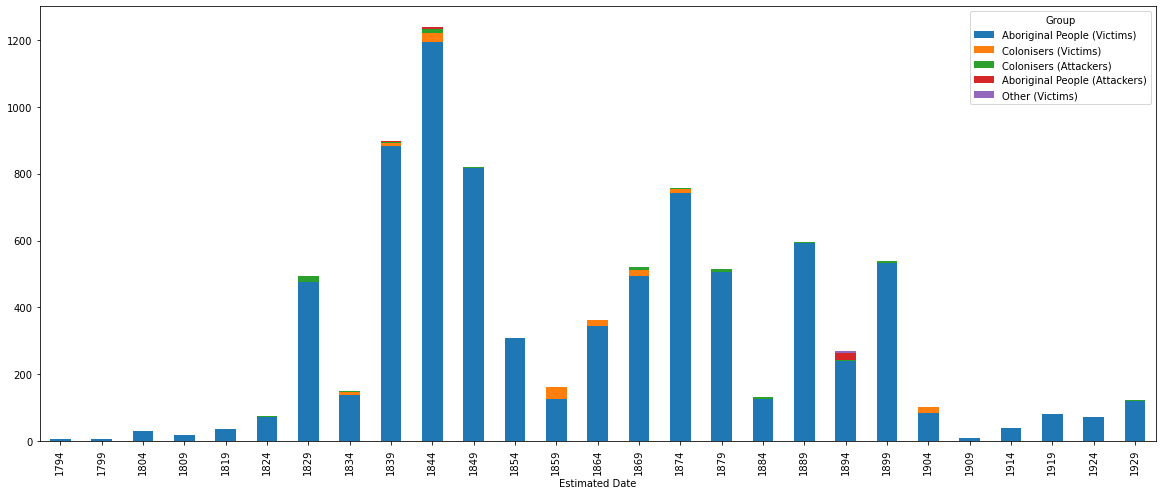

In [73]:
monthly_df.Group = monthly_df.Group.astype("category")
monthly_df = monthly_df.set_index(['Estimated Date', 'Group']).sort_index()

ax = monthly_df['Killed'].unstack().plot.bar(stacked=True,figsize=(20,8))
xtl = [item.get_text()[:4] for item in ax.get_xticklabels()]
_ = ax.set_xticklabels(xtl)

plt.savefig('aus-colonial-massacres.png')
